# exp003 EDA: 予測誤差分析

- 予測誤差の大きいサンプル分析
- 特徴量重要度の可視化
- 都道府県・市区町村別の誤差分析
- exp002との比較

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[2]
sys.path.insert(0, str(project_root / "04_src"))

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# 出力ディレクトリ
output_dir = Path.cwd().parent / "outputs"
notebook_output = Path.cwd() / "figures"
notebook_output.mkdir(exist_ok=True)

print(f"Project root: {project_root}")

Project root: /Users/kotaro/Desktop/ML/20251122_signamte_mlit


## 1. データ読み込み

In [2]:
# 最新のOOF予測ファイルを取得
oof_files = sorted(output_dir.glob("oof_predictions_*.csv"))
latest_oof = oof_files[-1] if oof_files else None

importance_files = sorted(output_dir.glob("feature_importance_*.csv"))
latest_importance = importance_files[-1] if importance_files else None

print(f"OOF file: {latest_oof}")
print(f"Importance file: {latest_importance}")

OOF file: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp003_baseline_v2/outputs/oof_predictions_20251125_133509.csv
Importance file: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp003_baseline_v2/outputs/feature_importance_20251125_133509.csv


In [3]:
# OOF予測読み込み
oof_df = pl.read_csv(latest_oof)
print(f"OOF予測: {oof_df.shape}")

# 元の訓練データ
train = pl.read_csv(project_root / "data" / "raw" / "train.csv", infer_schema_length=100000)
print(f"訓練データ: {train.shape}")

# マスターデータ
area_master = pl.read_csv(project_root / "data" / "master" / "area_master.csv")
area_master = area_master.with_columns([
    pl.col("addr1_1").cast(pl.Int64),
    pl.col("addr1_2").cast(pl.Int64),
])
print(f"エリアマスター: {area_master.shape}")

OOF予測: (363924, 3)


訓練データ: (363924, 149)
エリアマスター: (1953, 5)


## 2. 誤差計算

In [4]:
# 誤差列を追加
oof_df = oof_df.with_columns([
    (pl.col("predicted") - pl.col("actual")).alias("error"),
    ((pl.col("predicted") - pl.col("actual")).abs() / pl.col("actual") * 100).alias("ape"),
])

# 基本統計
print("誤差統計:")
print(f"  - 平均誤差 (ME): {oof_df['error'].mean():,.0f}円")
print(f"  - 平均絶対誤差 (MAE): {oof_df['error'].abs().mean():,.0f}円")
print(f"  - MAPE: {oof_df['ape'].mean():.2f}%")
print(f"  - 中央値APE: {oof_df['ape'].median():.2f}%")

誤差統計:
  - 平均誤差 (ME): -49,145円
  - 平均絶対誤差 (MAE): 5,659,613円
  - MAPE: 27.47%
  - 中央値APE: 18.56%


## 3. 予測誤差の分布

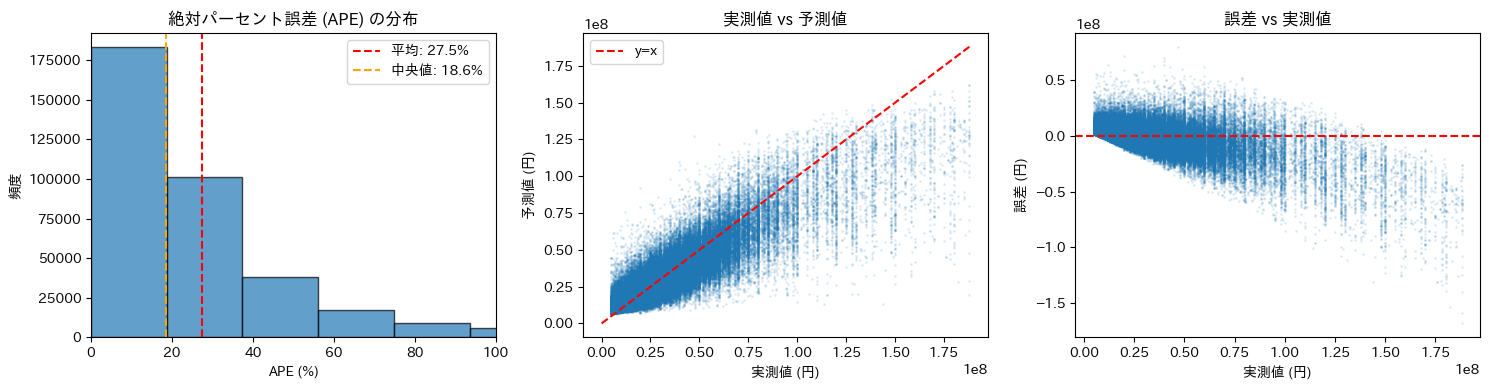

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# APE分布
ax = axes[0]
ape_values = oof_df["ape"].to_numpy()
ax.hist(ape_values, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(ape_values.mean(), color='red', linestyle='--', label=f'平均: {ape_values.mean():.1f}%')
ax.axvline(np.median(ape_values), color='orange', linestyle='--', label=f'中央値: {np.median(ape_values):.1f}%')
ax.set_xlabel("APE (%)")
ax.set_ylabel("頻度")
ax.set_title("絶対パーセント誤差 (APE) の分布")
ax.legend()
ax.set_xlim(0, 100)

# 実測値 vs 予測値
ax = axes[1]
actual = oof_df["actual"].to_numpy()
predicted = oof_df["predicted"].to_numpy()
ax.scatter(actual, predicted, alpha=0.1, s=1)
ax.plot([0, actual.max()], [0, actual.max()], 'r--', label='y=x')
ax.set_xlabel("実測値 (円)")
ax.set_ylabel("予測値 (円)")
ax.set_title("実測値 vs 予測値")
ax.legend()

# 誤差 vs 実測値
ax = axes[2]
ax.scatter(actual, oof_df["error"].to_numpy(), alpha=0.1, s=1)
ax.axhline(0, color='red', linestyle='--')
ax.set_xlabel("実測値 (円)")
ax.set_ylabel("誤差 (円)")
ax.set_title("誤差 vs 実測値")

plt.tight_layout()
plt.savefig(notebook_output / "error_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

## 4. 予測誤差の大きいサンプル分析

In [6]:
# 元データとOOF予測を結合
train_with_oof = train.with_row_index("row_id").join(
    oof_df.rename({"id": "row_id"}),
    on="row_id",
    how="left"
)

# エリア情報を結合
train_with_oof = train_with_oof.with_columns([
    pl.col("addr1_1").cast(pl.Int64),
    pl.col("addr1_2").cast(pl.Int64),
])
train_with_area = train_with_oof.join(
    area_master.select(["addr1_1", "addr1_2", "都道府県名", "市区町村名"]),
    on=["addr1_1", "addr1_2"],
    how="left"
)

In [7]:
# APE上位10件
print("APE上位10件（予測が大きく外れたサンプル）:")
top_errors = train_with_area.sort("ape", descending=True).head(10)
for i, row in enumerate(top_errors.iter_rows(named=True)):
    print(f"  {i+1}. APE={row['ape']:.1f}% | 実測={row['actual']:,.0f}円 | 予測={row['predicted']:,.0f}円")
    print(f"     {row['都道府県名']} {row['市区町村名']} | 面積={row['house_area']}㎡ | 築年={row['year_built']}")

APE上位10件（予測が大きく外れたサンプル）:


  1. APE=935.4% | 実測=5,950,000円 | 予測=61,605,526円
     東京都 青梅市 | 面積=2642.13㎡ | 築年=199211
  2. APE=895.4% | 実測=5,800,000円 | 予測=57,733,847円
     愛知県 名古屋市名東区 | 面積=5706.0㎡ | 築年=197008
  3. APE=847.8% | 実測=6,500,000円 | 予測=61,605,526円
     東京都 青梅市 | 面積=2642.13㎡ | 築年=199211
  4. APE=795.3% | 実測=5,000,000円 | 予測=44,766,799円
     静岡県 静岡市清水区 | 面積=262.67㎡ | 築年=198612
  5. APE=795.3% | 実測=5,000,000円 | 予測=44,766,799円
     静岡県 静岡市清水区 | 面積=262.67㎡ | 築年=198612
  6. APE=795.3% | 実測=5,000,000円 | 予測=44,766,799円
     静岡県 静岡市清水区 | 面積=262.67㎡ | 築年=198612
  7. APE=795.3% | 実測=5,000,000円 | 予測=44,766,799円
     静岡県 静岡市清水区 | 面積=262.0㎡ | 築年=198612
  8. APE=742.1% | 実測=5,900,000円 | 予測=49,684,502円
     北海道 札幌市北区 | 面積=53.01㎡ | 築年=None
  9. APE=711.4% | 実測=5,000,000円 | 予測=40,571,836円
     兵庫県 丹波市 | 面積=294.0㎡ | 築年=None
  10. APE=701.1% | 実測=4,980,000円 | 予測=39,893,316円
     千葉県 市原市 | 面積=612.74㎡ | 築年=193401


## 5. 特徴量重要度

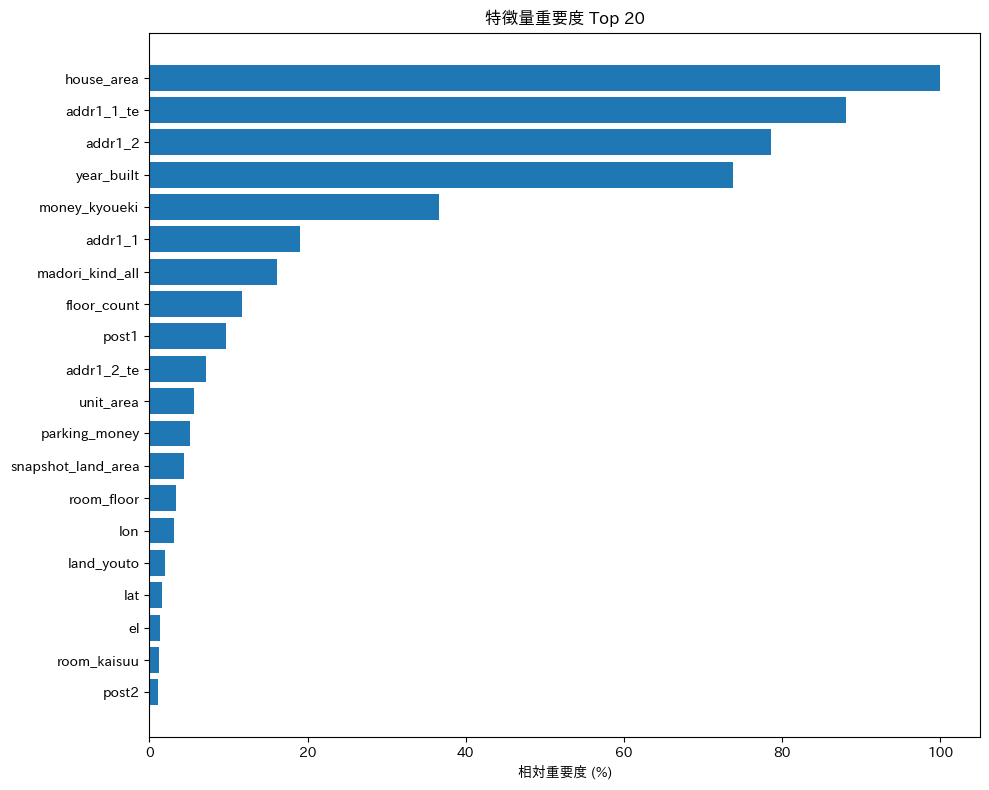

In [8]:
importance_df = pl.read_csv(latest_importance)
top_features = importance_df.head(20)

fig, ax = plt.subplots(figsize=(10, 8))
features = top_features["feature"].to_list()[::-1]
importance = top_features["importance"].to_list()[::-1]

# 正規化
importance_norm = np.array(importance) / max(importance) * 100

ax.barh(features, importance_norm)
ax.set_xlabel("相対重要度 (%)")
ax.set_title("特徴量重要度 Top 20")

plt.tight_layout()
plt.savefig(notebook_output / "feature_importance.png", dpi=150, bbox_inches='tight')
plt.show()

## 6. 都道府県別の誤差分析

In [9]:
pref_error = train_with_area.group_by("都道府県名").agg([
    pl.col("ape").mean().alias("mean_ape"),
    pl.col("ape").median().alias("median_ape"),
    pl.len().alias("count"),
]).sort("mean_ape", descending=True)

print("都道府県別 平均APE (上位10):")
for i, row in enumerate(pref_error.head(10).iter_rows(named=True)):
    print(f"  {i+1}. {row['都道府県名']}: {row['mean_ape']:.2f}% (n={row['count']:,})")

print("\n都道府県別 平均APE (下位10):")
for i, row in enumerate(pref_error.tail(10).iter_rows(named=True)):
    print(f"  {i+1}. {row['都道府県名']}: {row['mean_ape']:.2f}% (n={row['count']:,})")

都道府県別 平均APE (上位10):
  1. 和歌山県: 40.46% (n=3,330)
  2. 奈良県: 36.14% (n=3,759)
  3. 兵庫県: 35.58% (n=22,778)
  4. 京都府: 35.23% (n=13,018)
  5. 徳島県: 34.40% (n=287)
  6. 茨城県: 32.97% (n=5,525)
  7. 静岡県: 32.54% (n=9,544)
  8. 広島県: 32.51% (n=4,873)
  9. 鹿児島県: 32.33% (n=2,568)
  10. 福岡県: 32.24% (n=15,481)

都道府県別 平均APE (下位10):
  1. 大阪府: 24.94% (n=44,752)
  2. 鳥取県: 24.72% (n=527)
  3. 福井県: 24.01% (n=278)
  4. 熊本県: 23.13% (n=1,346)
  5. 岩手県: 23.02% (n=511)
  6. 宮崎県: 22.79% (n=1,773)
  7. 沖縄県: 22.63% (n=3,364)
  8. 山形県: 20.69% (n=351)
  9. 東京都: 20.28% (n=66,434)
  10. 大分県: 19.35% (n=339)


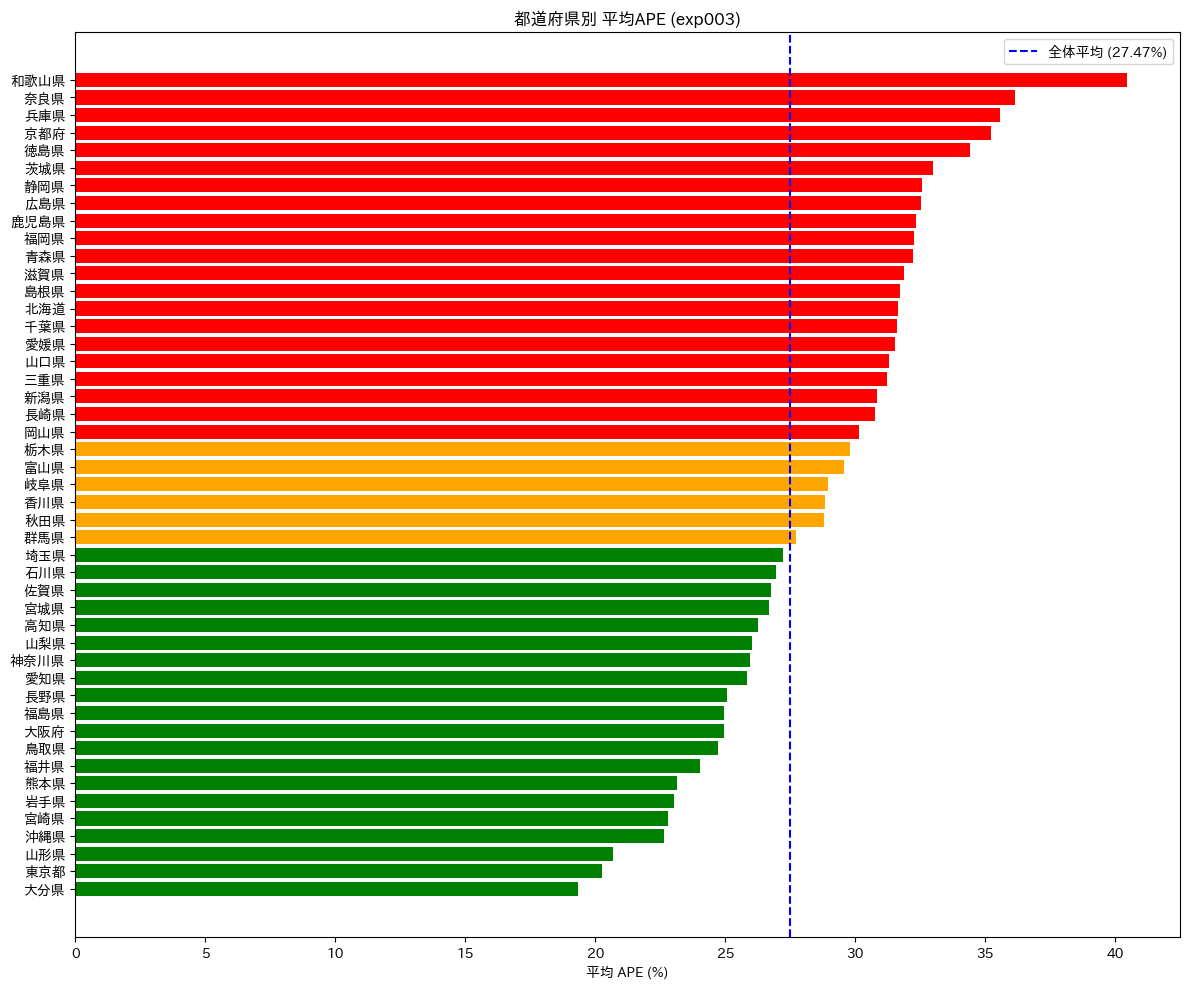

In [10]:
# 都道府県別APEの可視化
fig, ax = plt.subplots(figsize=(12, 10))
pref_sorted = pref_error.sort("mean_ape", descending=False)
prefs = pref_sorted["都道府県名"].to_list()
apes = pref_sorted["mean_ape"].to_list()

colors = ['red' if ape > 30 else 'orange' if ape > 27.5 else 'green' for ape in apes]
ax.barh(prefs, apes, color=colors)
ax.axvline(27.47, color='blue', linestyle='--', label='全体平均 (27.47%)')
ax.set_xlabel("平均 APE (%)")
ax.set_title("都道府県別 平均APE (exp003)")
ax.legend()

plt.tight_layout()
plt.savefig(notebook_output / "prefecture_ape.png", dpi=150, bbox_inches='tight')
plt.show()

## 7. 市区町村別の誤差分析

In [11]:
city_error = train_with_area.group_by(["都道府県名", "市区町村名"]).agg([
    pl.col("ape").mean().alias("mean_ape"),
    pl.col("ape").median().alias("median_ape"),
    pl.len().alias("count"),
]).filter(pl.col("count") >= 100).sort("mean_ape", descending=True)

print("市区町村別 平均APE (上位10、n>=100):")
for i, row in enumerate(city_error.head(10).iter_rows(named=True)):
    print(f"  {i+1}. {row['都道府県名']} {row['市区町村名']}: {row['mean_ape']:.2f}% (n={row['count']:,})")

print("\n市区町村別 平均APE (下位10、n>=100):")
for i, row in enumerate(city_error.tail(10).iter_rows(named=True)):
    print(f"  {i+1}. {row['都道府県名']} {row['市区町村名']}: {row['mean_ape']:.2f}% (n={row['count']:,})")

市区町村別 平均APE (上位10、n>=100):
  1. 兵庫県 西脇市: 93.99% (n=112)
  2. 滋賀県 高島市: 77.70% (n=124)
  3. 埼玉県 行田市: 73.44% (n=126)
  4. 埼玉県 本庄市: 71.94% (n=187)
  5. 東京都 青梅市: 71.54% (n=837)
  6. 福岡県 北九州市門司区: 70.98% (n=559)
  7. 埼玉県 入間郡毛呂山町: 70.51% (n=131)
  8. 兵庫県 たつの市: 68.40% (n=140)
  9. 静岡県 伊豆市: 65.74% (n=123)
  10. 京都府 舞鶴市: 64.48% (n=290)

市区町村別 平均APE (下位10、n>=100):
  1. 東京都 大田区: 16.12% (n=3,068)
  2. 東京都 文京区: 16.01% (n=1,418)
  3. 東京都 新宿区: 15.97% (n=2,788)
  4. 大阪府 大阪市西区: 15.92% (n=1,457)
  5. 大阪府 大阪市浪速区: 15.90% (n=727)
  6. 大阪府 大阪市北区: 15.90% (n=1,531)
  7. 大阪府 大阪市中央区: 15.75% (n=1,833)
  8. 東京都 千代田区: 15.26% (n=523)
  9. 東京都 中央区: 13.89% (n=2,050)
  10. 沖縄県 中頭郡北谷町: 13.40% (n=217)


## 8. 価格帯別の誤差分析

In [12]:
train_with_area = train_with_area.with_columns([
    pl.when(pl.col("actual") < 10_000_000).then(pl.lit("~1000万"))
    .when(pl.col("actual") < 15_000_000).then(pl.lit("1000~1500万"))
    .when(pl.col("actual") < 20_000_000).then(pl.lit("1500~2000万"))
    .when(pl.col("actual") < 30_000_000).then(pl.lit("2000~3000万"))
    .when(pl.col("actual") < 50_000_000).then(pl.lit("3000~5000万"))
    .otherwise(pl.lit("5000万~"))
    .alias("price_range")
])

price_error = train_with_area.group_by("price_range").agg([
    pl.col("ape").mean().alias("mean_ape"),
    pl.col("ape").median().alias("median_ape"),
    pl.len().alias("count"),
]).sort("mean_ape", descending=True)

print("価格帯別 平均APE:")
for row in price_error.iter_rows(named=True):
    print(f"  {row['price_range']}: {row['mean_ape']:.2f}% (中央値: {row['median_ape']:.2f}%, n={row['count']:,})")

価格帯別 平均APE:
  ~1000万: 71.33% (中央値: 60.85%, n=48,356)
  1000~1500万: 28.98% (中央値: 20.40%, n=57,370)
  1500~2000万: 22.00% (中央値: 17.34%, n=62,787)
  5000万~: 21.87% (中央値: 19.45%, n=26,174)
  2000~3000万: 17.50% (中央値: 14.33%, n=94,034)
  3000~5000万: 17.12% (中央値: 14.36%, n=75,203)


## 9. 築年数別の誤差分析

In [13]:
# 築年を抽出（year_builtは YYYYMM形式）
train_with_area = train_with_area.with_columns([
    (pl.col("year_built") // 100).alias("built_year")
])

# 築年数を計算（2024年基準）
train_with_area = train_with_area.with_columns([
    (2024 - pl.col("built_year")).alias("building_age")
])

# 築年数帯を作成
train_with_area = train_with_area.with_columns([
    pl.when(pl.col("building_age") < 5).then(pl.lit("~5年"))
    .when(pl.col("building_age") < 10).then(pl.lit("5~10年"))
    .when(pl.col("building_age") < 20).then(pl.lit("10~20年"))
    .when(pl.col("building_age") < 30).then(pl.lit("20~30年"))
    .when(pl.col("building_age") < 40).then(pl.lit("30~40年"))
    .otherwise(pl.lit("40年~"))
    .alias("age_range")
])

age_error = train_with_area.group_by("age_range").agg([
    pl.col("ape").mean().alias("mean_ape"),
    pl.col("ape").median().alias("median_ape"),
    pl.len().alias("count"),
]).sort("mean_ape", descending=True)

print("築年数帯別 平均APE:")
for row in age_error.iter_rows(named=True):
    print(f"  {row['age_range']}: {row['mean_ape']:.2f}% (中央値: {row['median_ape']:.2f}%, n={row['count']:,})")

築年数帯別 平均APE:
  ~5年: 41.71% (中央値: 24.74%, n=5,722)
  40年~: 33.91% (中央値: 22.19%, n=116,688)
  30~40年: 30.00% (中央値: 21.09%, n=78,374)
  20~30年: 23.76% (中央値: 17.11%, n=84,310)
  10~20年: 18.84% (中央値: 14.18%, n=57,193)
  5~10年: 17.17% (中央値: 13.07%, n=21,637)


## 10. exp002との比較

In [14]:
exp002_oof_dir = project_root / "06_experiments" / "exp002_feature_selection" / "outputs"
exp002_oof_files = sorted(exp002_oof_dir.glob("oof_predictions_*.csv"))

if exp002_oof_files:
    exp002_oof = pl.read_csv(exp002_oof_files[-1])
    exp002_oof = exp002_oof.with_columns([
        ((pl.col("predicted") - pl.col("actual")).abs() / pl.col("actual") * 100).alias("ape"),
    ])

    # 都道府県別で比較
    exp002_with_area = train.with_row_index("row_id").join(
        exp002_oof.rename({"id": "row_id"}),
        on="row_id",
        how="left"
    ).with_columns([
        pl.col("addr1_1").cast(pl.Int64),
        pl.col("addr1_2").cast(pl.Int64),
    ]).join(
        area_master.select(["addr1_1", "addr1_2", "都道府県名"]),
        on=["addr1_1", "addr1_2"],
        how="left"
    )

    exp002_pref = exp002_with_area.group_by("都道府県名").agg([
        pl.col("ape").mean().alias("exp002_ape"),
    ])

    exp003_pref = train_with_area.group_by("都道府県名").agg([
        pl.col("ape").mean().alias("exp003_ape"),
    ])

    comparison = exp002_pref.join(exp003_pref, on="都道府県名", how="inner")
    comparison = comparison.with_columns([
        (pl.col("exp003_ape") - pl.col("exp002_ape")).alias("improvement")
    ]).sort("improvement")

    print("改善が大きい都道府県 (上位10):")
    for i, row in enumerate(comparison.head(10).iter_rows(named=True)):
        print(f"  {i+1}. {row['都道府県名']}: {row['exp002_ape']:.2f}% → {row['exp003_ape']:.2f}% ({row['improvement']:+.2f}pt)")

    print("\n改善が小さい/悪化した都道府県 (下位10):")
    for i, row in enumerate(comparison.tail(10).iter_rows(named=True)):
        print(f"  {i+1}. {row['都道府県名']}: {row['exp002_ape']:.2f}% → {row['exp003_ape']:.2f}% ({row['improvement']:+.2f}pt)")

改善が大きい都道府県 (上位10):
  1. 岐阜県: 42.98% → 28.95% (-14.03pt)
  2. 佐賀県: 40.07% → 26.75% (-13.32pt)
  3. 和歌山県: 51.14% → 40.46% (-10.68pt)
  4. 山梨県: 35.97% → 26.02% (-9.95pt)
  5. 秋田県: 38.07% → 28.78% (-9.28pt)
  6. 奈良県: 45.38% → 36.14% (-9.25pt)
  7. 滋賀県: 40.41% → 31.89% (-8.52pt)
  8. 新潟県: 38.72% → 30.84% (-7.89pt)
  9. 香川県: 36.39% → 28.85% (-7.54pt)
  10. 岩手県: 29.97% → 23.02% (-6.95pt)

改善が小さい/悪化した都道府県 (下位10):
  1. 兵庫県: 35.34% → 35.58% (+0.24pt)
  2. 東京都: 19.93% → 20.28% (+0.34pt)
  3. 鹿児島県: 31.81% → 32.33% (+0.52pt)
  4. 広島県: 31.96% → 32.51% (+0.55pt)
  5. 大分県: 18.57% → 19.35% (+0.78pt)
  6. 神奈川県: 24.85% → 25.93% (+1.08pt)
  7. 埼玉県: 26.07% → 27.21% (+1.13pt)
  8. 沖縄県: 21.23% → 22.63% (+1.40pt)
  9. 宮城県: 25.27% → 26.68% (+1.41pt)
  10. 京都府: 32.83% → 35.23% (+2.40pt)


## 11. サマリー

In [15]:
print("="*60)
print("EDA サマリー")
print("="*60)

print(f"""
【モデル性能】
  - CV MAPE: 27.47%
  - 特徴量数: 83個
  - exp002からの改善: -0.79pt

【誤差傾向】
  - 高APE都道府県: 和歌山県、奈良県、兵庫県など
  - 低APE都道府県: 大分県、東京都、山形県など
  - 低価格帯（~1000万）の予測が困難

【重要特徴量 Top 5】
  1. house_area（専有面積）
  2. addr1_1_te（都道府県TE）
  3. addr1_2（市区町村コード）
  4. year_built（築年）
  5. money_kyoueki（共益費）

【次のアクション候補】
  1. 低価格帯の特別処理（外れ値除外、別モデル）
  2. 築年数の非線形変換
  3. 交互作用特徴量の追加
  4. 和歌山・奈良など高APE地域の詳細分析
""")

EDA サマリー

【モデル性能】
  - CV MAPE: 27.47%
  - 特徴量数: 83個
  - exp002からの改善: -0.79pt

【誤差傾向】
  - 高APE都道府県: 和歌山県、奈良県、兵庫県など
  - 低APE都道府県: 大分県、東京都、山形県など
  - 低価格帯（~1000万）の予測が困難

【重要特徴量 Top 5】
  1. house_area（専有面積）
  2. addr1_1_te（都道府県TE）
  3. addr1_2（市区町村コード）
  4. year_built（築年）
  5. money_kyoueki（共益費）

【次のアクション候補】
  1. 低価格帯の特別処理（外れ値除外、別モデル）
  2. 築年数の非線形変換
  3. 交互作用特徴量の追加
  4. 和歌山・奈良など高APE地域の詳細分析

